## Question 7 - FasterRCNN

In [61]:
import os
import glob

import cv2
import torch
import torchvision
import numpy as np
from PIL import Image

import pandas as pd
from pathlib import Path

from tqdm import tqdm
from collections import Counter
from xml.etree import ElementTree as ET

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

In [62]:
MODEL_NAME = 'data/weights_masks.pth'

class_dict = {"with_mask": 1, 
              "without_mask": 2, 
              "mask_weared_incorrect": 3}

class_dct_inv  = {1: 'with_mask', 
                  2: "without_mask", 
                  3: "mask_weared_incorrect"}

In [63]:
import albumentations as A #note installing this changes your version of OpenCV and you loose sift
from albumentations.pytorch import ToTensorV2

bbox_params = A.BboxParams(
        format = 'pascal_voc',
        label_fields = ['labels'],
        min_visibility = 0.3
)

test_transform = A.Compose([
        A.Resize(height=480, width=480),
#         A.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225]),
        ToTensorV2(p=1.0)],
        bbox_params = bbox_params
)

# bbox_params = A.BboxParams(
#     format='pascal_voc',
#     min_area=5,  # 5
#     min_visibility=0.9,  # 0.9
#     #     check_each_transform =True,
#     label_fields=['labels']
# )

# test_transform = A.Compose([
#     A.Resize(height=446, width=446),
#     ToTensorV2()],
#     bbox_params=bbox_params,
#     is_check_shapes=False
# )

## Load the model

In [64]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [65]:
def get_model_detection(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [66]:
device='cuda' if torch.cuda.is_available() else 'cpu'
model = get_model_detection(4)

model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')), False)
model.eval()
model.to(device)

D:\Anaconda3\envs\what\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda3\envs\what\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Load the dataset

In [67]:
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=4, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=16, bias=True)
)

In [68]:
model.roi_heads.box_predictor.cls_score.weight

Parameter containing:
tensor([[-0.0034, -0.0309,  0.0127,  ..., -0.0032,  0.0060, -0.0092],
        [-0.0279,  0.0228, -0.0226,  ...,  0.0033, -0.0116,  0.0315],
        [ 0.0014, -0.0015,  0.0290,  ...,  0.0268,  0.0039, -0.0081],
        [-0.0322, -0.0034, -0.0322,  ..., -0.0224,  0.0004, -0.0206]],
       requires_grad=True)

In [ ]:
from bs4 import BeautifulSoup

class MaskedFaceTestDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_imgs, path_to_xml_files, transform=None):
        self.path_to_imgs = path_to_imgs
        self.path_to_xml_files = path_to_xml_files
        self.transform = transform

        self.file_names = [file for file in os.listdir(self.path_to_imgs) if file.endswith(".png")]

        self.file_paths = [os.path.join(self.path_to_imgs, file_name) for file_name in self.file_names]

    def __getitem__(self, index: int):
        path_to_img = self.file_paths[index]
        path = Path(path_to_img)
        fname = path.stem

        self.name = self.file_names[index]

        image = Image.open(path_to_img).convert('RGB')
        image = np.array(image) / 255.0

        target = self.__generate_target(self.path_to_xml_files, self.name)

        if self.transform:
            augmentations = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])

            image = augmentations['image']

            target['boxes'] = torch.tensor(augmentations['bboxes'])

            target['labels'] = torch.tensor(augmentations['labels'])

        return image, target, fname

    def __generate_target(self, path_to_xml, name_of_img):
        path_to_annot = os.path.join(path_to_xml, name_of_img.replace('png', 'xml'))

        boxes_lst = []
        labels_lst = []
        clases_lst = []
        target = {}

        with open(path_to_annot, 'r') as file:
            xml_content = file.read()

        soup = BeautifulSoup(xml_content, 'xml')

        objects = soup.find_all('object')

        for obj in objects:
            name = obj.find('name').text
            xmin = int(float(obj.find('xmin').text)) - 1
            ymin = int(float(obj.find('ymin').text)) - 1
            xmax = int(float(obj.find('xmax').text)) - 1
            ymax = int(float(obj.find('ymax').text)) - 1

            labels_lst.append(name)
            boxes_lst.append([xmin, ymin, xmax, ymax])
            clases_lst.append(class_dict[name])

        target["boxes"] = torch.tensor(boxes_lst, dtype=torch.float32)
        target["labels"] = torch.tensor(clases_lst, dtype=torch.int64)

        return target

    def __len__(self):
        return len(self.file_paths)

In [ ]:
import xmltodict
from torch.utils.data.sampler import SubsetRandomSampler

def collate_fn(batch):
    return tuple(zip(*batch))

test_ds = MaskedFaceTestDataset(path_to_imgs = './data/MaskedFace/val/',
                               path_to_xml_files = './data/MaskedFace/val/',
                               transform = test_transform)

test_sampler = SubsetRandomSampler( list(range(0, len(test_ds))) )

test_loader = DataLoader(test_ds, batch_size=16, num_workers=0, pin_memory=True,
                             sampler=test_sampler, collate_fn=collate_fn)

## Test an image

In [40]:
index = 10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


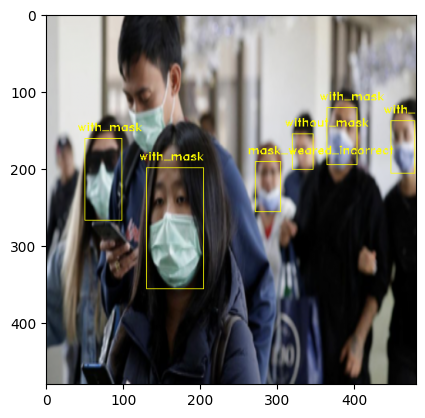

In [41]:
import matplotlib.pyplot as plt

image, target, fname = test_ds[index]

cv_image = np.transpose(image, (1, 2, 0)).numpy()

for box, label in zip(target['boxes'], target['labels']):
    cv2.rectangle(cv_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 255, 0))
    cv2.putText(cv_image, 
                class_dct_inv[label.item()], 
                (int(box[0])-10, int(box[1])-10),
                cv2.FONT_HERSHEY_DUPLEX,
                0.5,
                (255, 255, 0), 
               )

plt.imshow(cv_image)
plt.show()

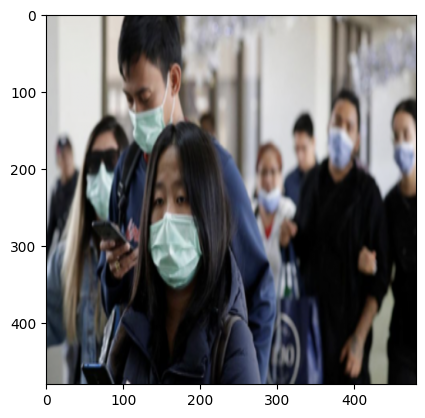

In [42]:
model.eval()

image, target, fname = test_ds[index]

with torch.no_grad():
    prediction = model(image.unsqueeze(0).to(device, dtype=torch.float))[0]

cv_image = np.transpose(image, (1, 2, 0)).numpy()

for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
    if score >= 0.5:
        cv2.rectangle(cv_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 255, 0))
        cv2.putText(cv_image, 
                    class_dct_inv[label.item()], 
                    (int(box[0])-10, int(box[1])-10),
                    cv2.FONT_HERSHEY_DUPLEX,
                    0.5,
                    (255, 255, 0), 
                   )

plt.imshow(cv_image)
plt.show()

## Evaluation on the Test set

In [69]:
def read_true_object(root):
    for child in root:
        if child.tag == "name":
            label_desc = str(child.text)
            if label_desc == "with_mask":
                return class_dict["with_mask"]
            elif label_desc == "without_mask":
                return class_dict["without_mask"]
            else:
                return class_dict["mask_weared_incorrect"]

def get_true_result(filename):
    wi_m = 0
    wo_m = 0
    inc_m = 0
    tree = ET.parse('./data/MaskedFace/val/' + filename + ".xml")
    root = tree.getroot()
    result = None
    for child in root:
        if child.tag == "object":
            result = read_true_object(child)
            if result == class_dict["with_mask"]:
                wi_m+=1
            elif result == class_dict["without_mask"]:
                wo_m+=1
            elif result == class_dict["mask_weared_incorrect"]:
                inc_m+=1
    return [wi_m, wo_m, inc_m]

In [70]:
pred_list = []
true_list = []

model.eval()

for images, targets, fname in tqdm(test_loader):
    for i in range(len(fname)):
        true_list.append(get_true_result(fname[i]))

    images = list(image.to(device, dtype=torch.float) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        prediction = model(images)

    for i in range(len(images)):
        with_m = 0
        with_o_m = 0
        wrong_m = 0

        for pred in range(len(prediction[i]['boxes'])):

            box = prediction[i]['boxes'][pred].cpu().numpy()
            label = prediction[i]['labels'][pred].cpu().numpy()
            score = prediction[i]['scores'][pred].cpu().numpy()

            if score >= 0.5:
                if label.item() == class_dict["with_mask"]:
                    with_m += 1
                elif label.item() == class_dict["without_mask"]:
                    with_o_m += 1
                elif label.item() == class_dict["mask_weared_incorrect"]:
                    wrong_m += 1

        pred_list.append([int(with_m), int(with_o_m), int(wrong_m)])

  0%|                                                                                                                                 | 0/6 [00:01<?, ?it/s]


RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 655360000 bytes.

## MAPE

In [14]:
def compute_mape(prediction, truth):
    mape = np.mean( np.abs(truth - prediction) / np.maximum(truth, np.ones_like(truth)) ) * 100
    return mape

In [15]:
MAPE = compute_mape( np.array(pred_list), np.array(true_list) )

In [16]:
print(MAPE)

45.09803921568628


## Final Score

In [17]:
if MAPE <= 10:
    print("Score: ", 25*1.0)
elif MAPE <= 15:
    print("Score: ", 25*0.875)
elif MAPE <= 20:
    print("Score: ", 25*0.75)
elif MAPE <= 25:
    print("Score: ", 25*0.625)
elif MAPE <= 30:
    print("Score: ", 25*0.5)
else:
    print("Score: ", 0)  

Score:  0
